# Entraînement des modèles pour la détection de pneumonie

Ce notebook présente l'entraînement et l'évaluation de différents modèles de deep learning pour la détection de pneumonie à partir d'images radiographiques.

In [1]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pour éviter les avertissements
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

# Définir le chemin vers les données
data_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\data'

# Fonction pour charger les images
def load_images_from_dir(directory, img_size=(224, 224), max_images=None):
    """
    Charge les images d'un répertoire avec leurs étiquettes.
    
    Args:
        directory (str): Chemin vers le répertoire contenant les images
        img_size (tuple): Taille des images après redimensionnement
        max_images (int): Nombre maximum d'images à charger par classe
        
    Returns:
        tuple: Images, étiquettes et noms de fichiers
    """
    images = []
    labels = []
    filenames = []
    
    # Vérifier si le répertoire existe
    if not os.path.exists(directory):
        print(f"Le répertoire {directory} n'existe pas.")
        return np.array([]), np.array([], dtype=int), []
    
    # Parcourir les sous-répertoires (classes)
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Déterminer l'étiquette (0 pour normal, 1 pour pneumonie)
        label = 0 if class_name.lower() == 'normal' else 1
        
        # Parcourir les images dans le sous-répertoire
        img_count = 0
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            if max_images is not None and img_count >= max_images:
                break
                
            img_path = os.path.join(class_dir, img_name)
            
            # Charger et prétraiter l'image
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Impossible de charger l'image {img_path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB
                img = cv2.resize(img, img_size)  # Redimensionner
                
                images.append(img)
                labels.append(label)
                filenames.append(img_path)
                img_count += 1
            except Exception as e:
                print(f"Erreur lors du chargement de l'image {img_path}: {e}")
    
    # Convertir les labels en int pour éviter l'erreur avec bincount
    return np.array(images), np.array(labels, dtype=int), filenames

# Vérifier la structure du dossier de données
print(f"Vérification du dossier de données: {data_dir}")
if os.path.exists(data_dir):
    print("Le dossier de données existe.")
    print(f"Contenu du dossier: {os.listdir(data_dir)}")
else:
    print("Le dossier de données n'existe pas!")

# Vérifier si le dossier a la structure attendue (train, val, test)
expected_structure = ['train', 'val', 'test']
has_expected_structure = all(os.path.isdir(os.path.join(data_dir, d)) for d in expected_structure)

if has_expected_structure:
    # Charger les images depuis les sous-dossiers train, val et test
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')
    
    print("\nChargement des images...")
    X_train, y_train, train_filenames = load_images_from_dir(train_dir)
    X_val, y_val, val_filenames = load_images_from_dir(val_dir)
    X_test, y_test, test_filenames = load_images_from_dir(test_dir)
    
    # Afficher le nombre d'images chargées
    print(f"\nNombre d'images chargées:")
    print(f"  - Train: {len(X_train)} images")
    print(f"  - Validation: {len(X_val)} images")
    print(f"  - Test: {len(X_test)} images")
    
    # Afficher la distribution des classes
    print("\nDistribution des classes:")
    if len(y_train) > 0:
        print(f"  - Train: {np.bincount(y_train)}")
    if len(y_val) > 0:
        print(f"  - Validation: {np.bincount(y_val)}")
    if len(y_test) > 0:
        print(f"  - Test: {np.bincount(y_test)}")
    
    # Normaliser les images
    print("\nNormalisation des images...")
    X_train = X_train / 255.0 if len(X_train) > 0 else X_train
    X_val = X_val / 255.0 if len(X_val) > 0 else X_val
    X_test = X_test / 255.0 if len(X_test) > 0 else X_test
else:
    # Structure alternative: charger directement depuis le dossier principal
    print("\nStructure de dossier standard non trouvée. Recherche d'une structure alternative...")
    
    # Vérifier s'il y a des dossiers de classes directement dans le dossier principal
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d not in expected_structure]
    
    if class_dirs:
        print(f"Dossiers de classes trouvés: {class_dirs}")
        
        # Charger toutes les images
        print("\nChargement des images...")
        X, y, filenames = load_images_from_dir(data_dir)
        
        # Diviser les données en ensembles d'entraînement, de validation et de test
        if len(X) > 0:
            # Diviser d'abord en train+val et test (80% / 20%)
            X_temp, X_test, y_temp, y_test, filenames_temp, test_filenames = train_test_split(
                X, y, filenames, test_size=0.2, random_state=42, stratify=y
            )
            
            # Diviser train+val en train et val (90% / 10% du total, soit 72% / 8%)
            X_train, X_val, y_train, y_val, train_filenames, val_filenames = train_test_split(
                X_temp, y_temp, filenames_temp, test_size=0.1, random_state=42, stratify=y_temp
            )
            
            # Afficher le nombre d'images chargées
            print(f"\nNombre d'images chargées et divisées:")
            print(f"  - Train: {len(X_train)} images")
            print(f"  - Validation: {len(X_val)} images")
            print(f"  - Test: {len(X_test)} images")
            
            # Afficher la distribution des classes
            print("\nDistribution des classes:")
            print(f"  - Train: {np.bincount(y_train)}")
            print(f"  - Validation: {np.bincount(y_val)}")
            print(f"  - Test: {np.bincount(y_test)}")
            
            # Normaliser les images
            print("\nNormalisation des images...")
            X_train = X_train / 255.0
            X_val = X_val / 255.0
            X_test = X_test / 255.0
        else:
            print("Aucune image n'a été chargée.")
            X_train, y_train, train_filenames = np.array([]), np.array([], dtype=int), []
            X_val, y_val, val_filenames = np.array([]), np.array([], dtype=int), []
            X_test, y_test, test_filenames = np.array([]), np.array([], dtype=int), []
    else:
        print("Aucune structure de données valide n'a été trouvée.")
        X_train, y_train, train_filenames = np.array([]), np.array([], dtype=int), []
        X_val, y_val, val_filenames = np.array([]), np.array([], dtype=int), []
        X_test, y_test, test_filenames = np.array([]), np.array([], dtype=int), []

print("\nPréparation des données terminée.")

Vérification du dossier de données: C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\data
Le dossier de données existe.
Contenu du dossier: ['test', 'train', 'val']

Chargement des images...

Nombre d'images chargées:
  - Train: 5216 images
  - Validation: 16 images
  - Test: 624 images

Distribution des classes:
  - Train: [1341 3875]
  - Validation: [8 8]
  - Test: [234 390]

Normalisation des images...

Préparation des données terminée.


In [2]:
# Fonction pour créer un modèle CNN simple
def create_cnn_model(input_shape=(224, 224, 3)):
    """
    Crée un modèle CNN simple.
    
    Args:
        input_shape (tuple): Forme des images d'entrée
        
    Returns:
        tensorflow.keras.models.Model: Modèle CNN
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sortie binaire: normal vs pneumonie
    ])
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Fonction pour créer un modèle VGG16
def create_vgg16_model(input_shape=(224, 224, 3)):
    """
    Crée un modèle utilisant le transfer learning avec VGG16.
    
    Args:
        input_shape (tuple): Forme des images d'entrée
        
    Returns:
        tensorflow.keras.models.Model: Modèle de transfer learning
    """
    # Charger le modèle VGG16 pré-entraîné sans les couches fully-connected
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Geler les couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False
    
    # Ajouter des couches personnalisées
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Taux d'apprentissage plus faible pour le transfer learning
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Fonction pour créer un modèle ResNet50
def create_resnet50_model(input_shape=(224, 224, 3)):
    """
    Crée un modèle utilisant le transfer learning avec ResNet50.
    
    Args:
        input_shape (tuple): Forme des images d'entrée
        
    Returns:
        tensorflow.keras.models.Model: Modèle de transfer learning
    """
    # Charger le modèle ResNet50 pré-entraîné sans les couches fully-connected
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Geler les couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False
    
    # Ajouter des couches personnalisées
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Taux d'apprentissage plus faible pour le transfer learning
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [3]:
# Fonction pour entraîner un modèle
def train_model(model, X_train, y_train, X_val, y_val, model_name='model', 
                batch_size=32, epochs=20, use_augmentation=True):
    """
    Entraîne un modèle avec ou sans augmentation de données.
    
    Args:
        model: Modèle à entraîner
        X_train (numpy.ndarray): Images d'entraînement
        y_train (numpy.ndarray): Étiquettes d'entraînement
        X_val (numpy.ndarray): Images de validation
        y_val (numpy.ndarray): Étiquettes de validation
        model_name (str): Nom du modèle pour la sauvegarde
        batch_size (int): Taille du batch
        epochs (int): Nombre d'époques
        use_augmentation (bool): Utiliser l'augmentation de données
        
    Returns:
        tuple: Modèle entraîné et historique d'entraînement
    """
    # Vérifier si les données d'entraînement sont disponibles
    if len(X_train) == 0 or len(y_train) == 0:
        print("Erreur: Données d'entraînement vides.")
        return None, None
    
    # Créer le répertoire de résultats s'il n'existe pas
    results_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results'
    os.makedirs(results_dir, exist_ok=True)
    
    # Définir les callbacks
    callbacks = [
        # Sauvegarde du meilleur modèle
        ModelCheckpoint(
            filepath=os.path.join(results_dir, f'{model_name}.h5'),
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        # Arrêt anticipé si pas d'amélioration
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            restore_best_weights=True  # Restaurer les meilleurs poids
        ),
        # Réduction du taux d'apprentissage si plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            verbose=1,
            min_lr=1e-6
        )
    ]
    
    print(f"Début de l'entraînement du modèle {model_name}...")
    print(f"Nombre d'images d'entraînement: {len(X_train)}")
    print(f"Nombre d'images de validation: {len(X_val)}")
    print(f"Utilisation de l'augmentation de données: {use_augmentation}")
    
    try:
        # Entraînement avec ou sans augmentation de données
        if use_augmentation:
            # Configurer le générateur d'augmentation
            datagen = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )
            
            # Adapter le générateur aux données d'entraînement
            datagen.fit(X_train)
            
            # Calculer le nombre d'étapes par époque
            steps_per_epoch = len(X_train) // batch_size
            if steps_per_epoch == 0:  # Éviter les divisions par zéro
                steps_per_epoch = 1
            
            # Entraîner le modèle avec le générateur
            history = model.fit(
                datagen.flow(X_train, y_train, batch_size=batch_size),
                steps_per_epoch=steps_per_epoch,
                epochs=epochs,
                validation_data=(X_val, y_val),
                callbacks=callbacks,
                verbose=1
            )
        else:
            # Entraîner le modèle sans augmentation
            history = model.fit(
                X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val),
                callbacks=callbacks,
                verbose=1
            )
        
        print(f"Entraînement terminé après {len(history.epoch)} époques.")
        
        # Vérifier si le fichier du modèle existe
        model_path = os.path.join(results_dir, f'{model_name}.h5')
        if os.path.exists(model_path):
            # Charger le meilleur modèle
            print(f"Chargement du meilleur modèle depuis {model_path}")
            best_model = load_model(model_path)
            return best_model, history
        else:
            print(f"Attention: Le fichier du modèle {model_path} n'a pas été créé.")
            return model, history  # Retourner le modèle actuel
            
    except Exception as e:
        print(f"Erreur lors de l'entraînement du modèle {model_name}: {e}")
        return model, None  # Retourner le modèle non entraîné en cas d'erreur

# Fonction pour évaluer un modèle
def evaluate_model(model, X_test, y_test, model_name='Modèle', class_names=['Normal', 'Pneumonie']):
    """
    Évalue les performances d'un modèle sur l'ensemble de test.
    
    Args:
        model: Modèle à évaluer
        X_test (numpy.ndarray): Images de test
        y_test (numpy.ndarray): Étiquettes de test
        model_name (str): Nom du modèle
        class_names (list): Noms des classes
        
    Returns:
        dict: Métriques d'évaluation
    """
    # Vérifier si le modèle et les données de test sont disponibles
    if model is None:
        print(f"Erreur: Le modèle {model_name} n'est pas disponible.")
        return {}
    
    if len(X_test) == 0 or len(y_test) == 0:
        print(f"Erreur: Données de test vides pour le modèle {model_name}.")
        return {}
    
    print(f"\nÉvaluation du modèle {model_name}...")
    
    try:
        # Prédire les probabilités
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        
        # Convertir les probabilités en classes
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Calculer les métriques
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Calculer la matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        
        # Calculer la spécificité (taux de vrais négatifs)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        
        # Calculer la valeur prédictive négative (VPN)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        # Afficher les résultats
        print(f"\nRésultats pour le modèle {model_name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall (Sensibilité): {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print(f"NPV: {npv:.4f}")
        
        # Afficher la matrice de confusion
        print("\nMatrice de confusion:")
        print(cm)
        
        # Afficher le rapport de classification
        print("\nRapport de classification:")
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        # Visualiser la matrice de confusion
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Prédiction')
        plt.ylabel('Vérité')
        plt.title(f'Matrice de confusion - {model_name}')
        plt.show()
        
        # Tracer la courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title(f'Courbe ROC - {model_name}')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Visualiser la distribution des probabilités prédites
        plt.figure(figsize=(12, 6))
        
        # Séparer les prédictions par classe réelle
        normal_probs = y_pred_proba[y_test == 0]
        pneumonia_probs = y_pred_proba[y_test == 1]
        
        plt.hist(normal_probs, bins=20, alpha=0.5, color='blue', label='Normal')
        plt.hist(pneumonia_probs, bins=20, alpha=0.5, color='red', label='Pneumonie')
        
        plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil (0.5)')
        plt.xlabel('Probabilité prédite de pneumonie')
        plt.ylabel('Nombre d\'images')
        plt.title(f'Distribution des probabilités prédites - {model_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Retourner les métriques
        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1,
            'auc': auc,
            'npv': npv,
            'confusion_matrix': cm,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        return metrics
    
    except Exception as e:
        print(f"Erreur lors de l'évaluation du modèle {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return {}


1. Modèle CNN
Chargement du modèle CNN depuis C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results\cnn_model.h5

Évaluation du modèle CNN...

Résultats pour le modèle CNN:
Accuracy: 0.8622
Precision: 0.9318
Recall (Sensibilité): 0.8410
Specificity: 0.8974
F1-score: 0.8841
AUC: 0.9488
NPV: 0.7721

Matrice de confusion:
[[210  24]
 [ 62 328]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.77      0.90      0.83       234
   Pneumonie       0.93      0.84      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.87      0.86       624
weighted avg       0.87      0.86      0.86       624



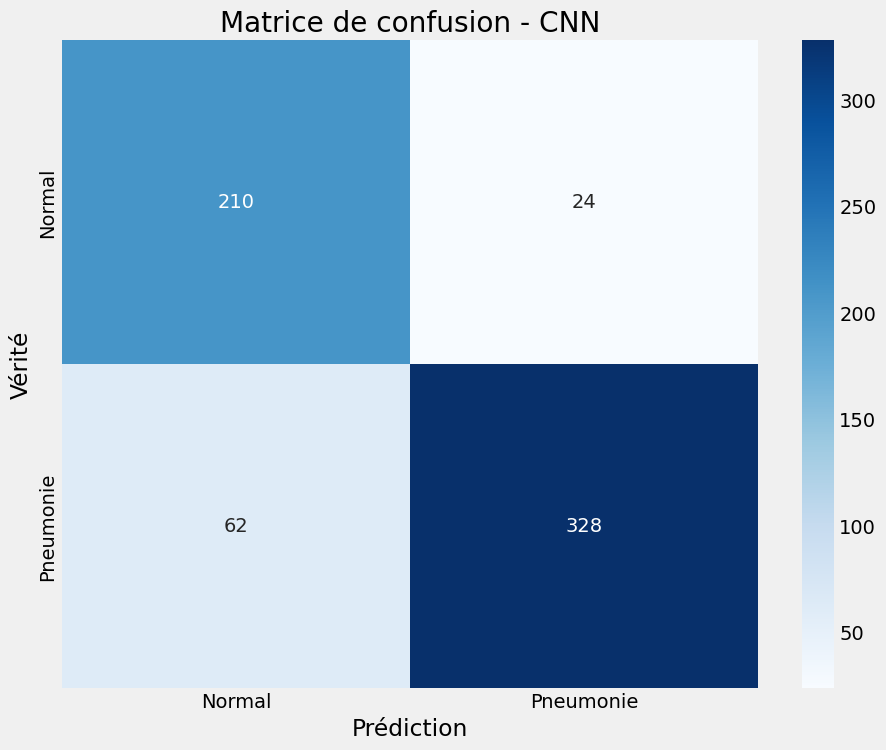

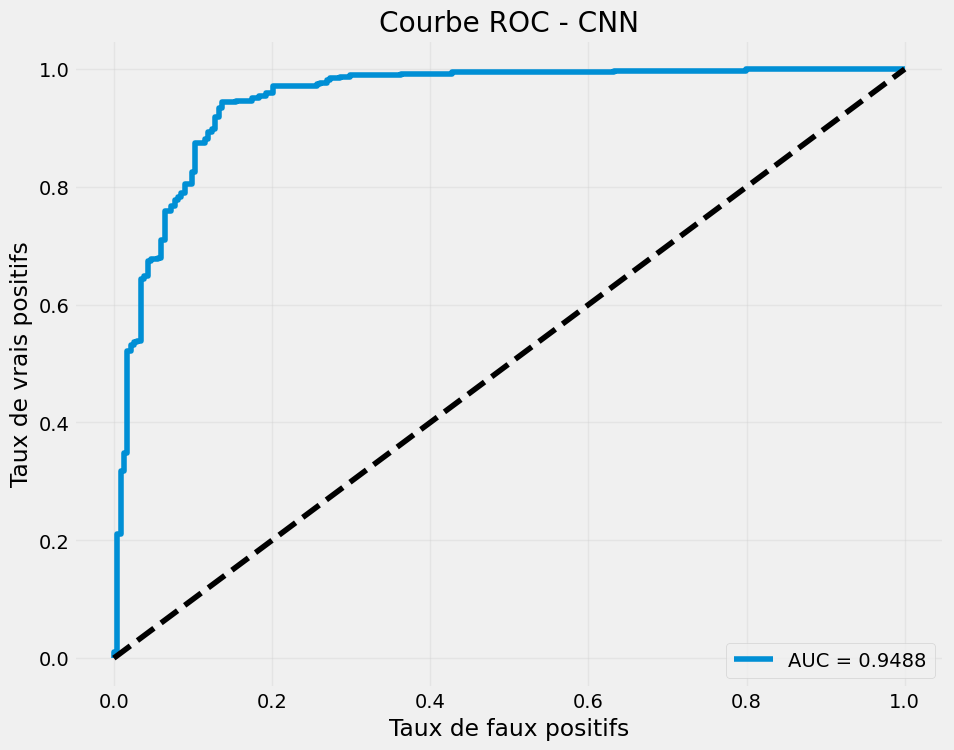

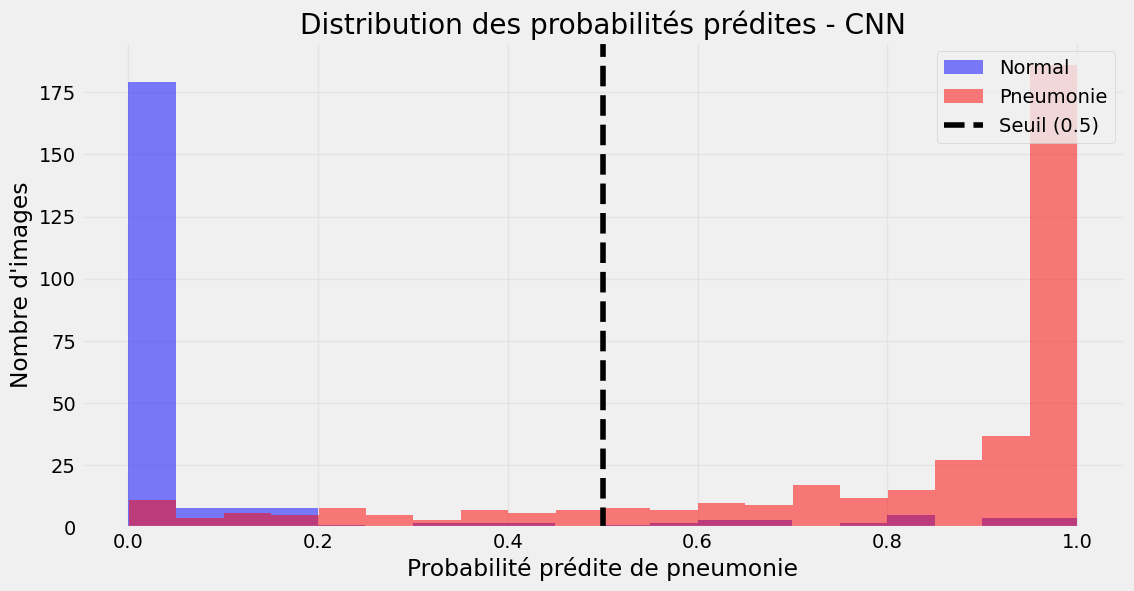


2. Modèle VGG16
Création du modèle VGG16...
58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                 

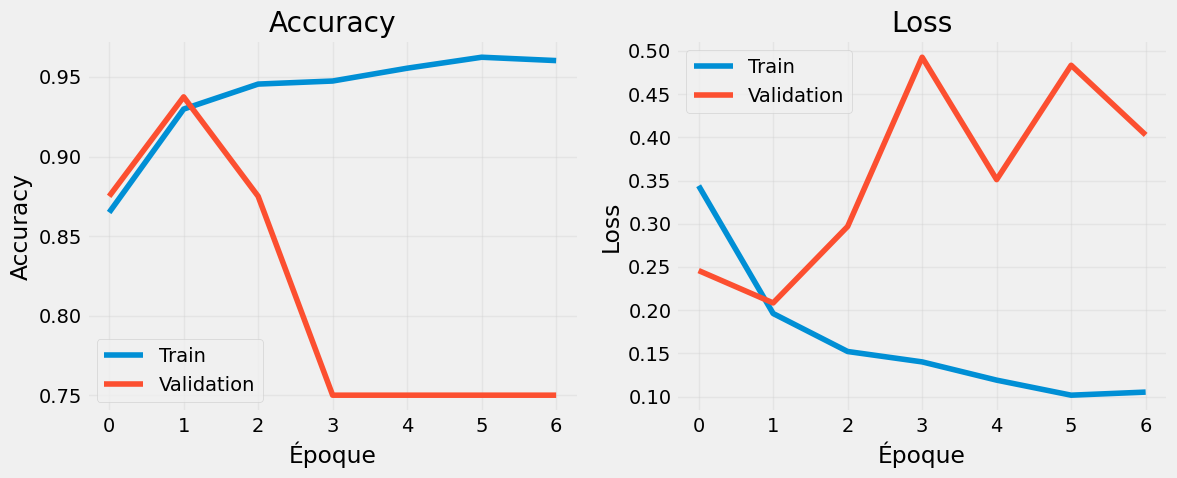


Évaluation du modèle VGG16...

Résultats pour le modèle VGG16:
Accuracy: 0.8958
Precision: 0.8702
Recall (Sensibilité): 0.9795
Specificity: 0.7564
F1-score: 0.9216
AUC: 0.9523
NPV: 0.9568

Matrice de confusion:
[[177  57]
 [  8 382]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.96      0.76      0.84       234
   Pneumonie       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624



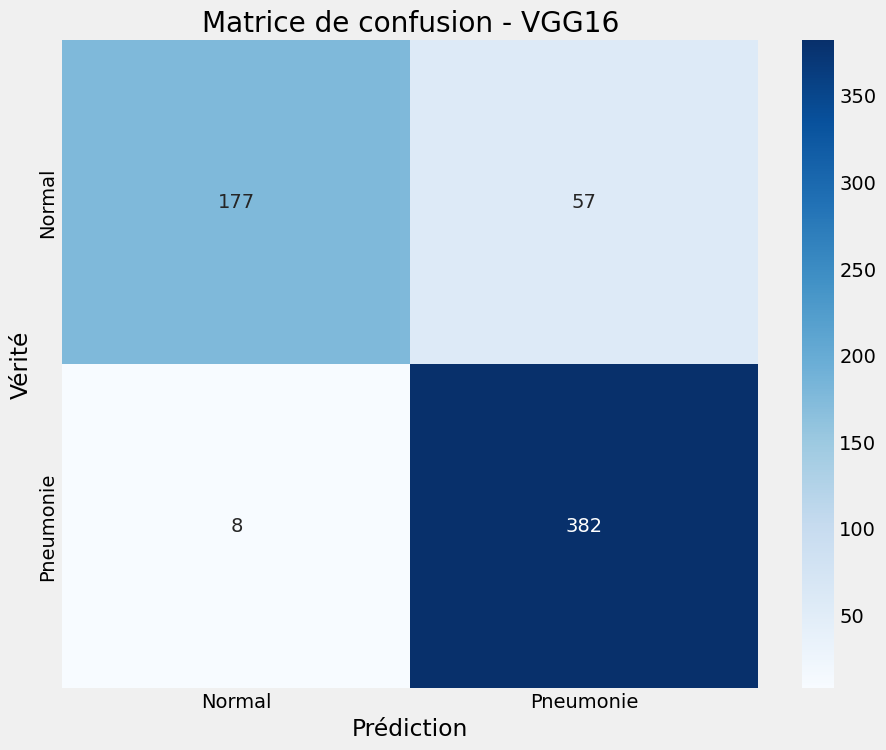

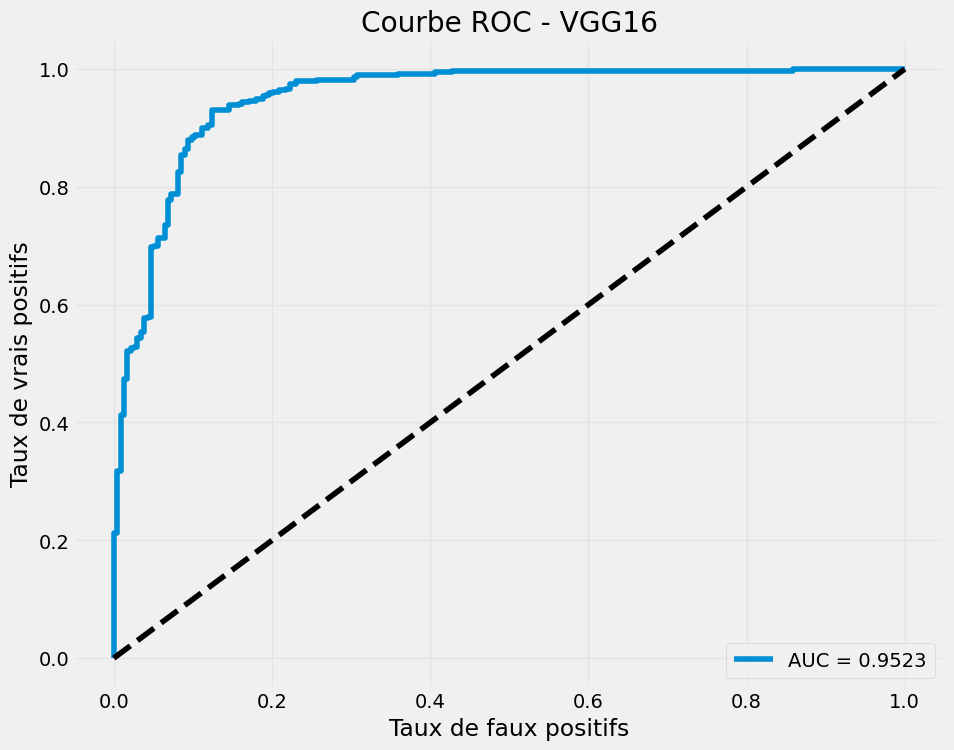

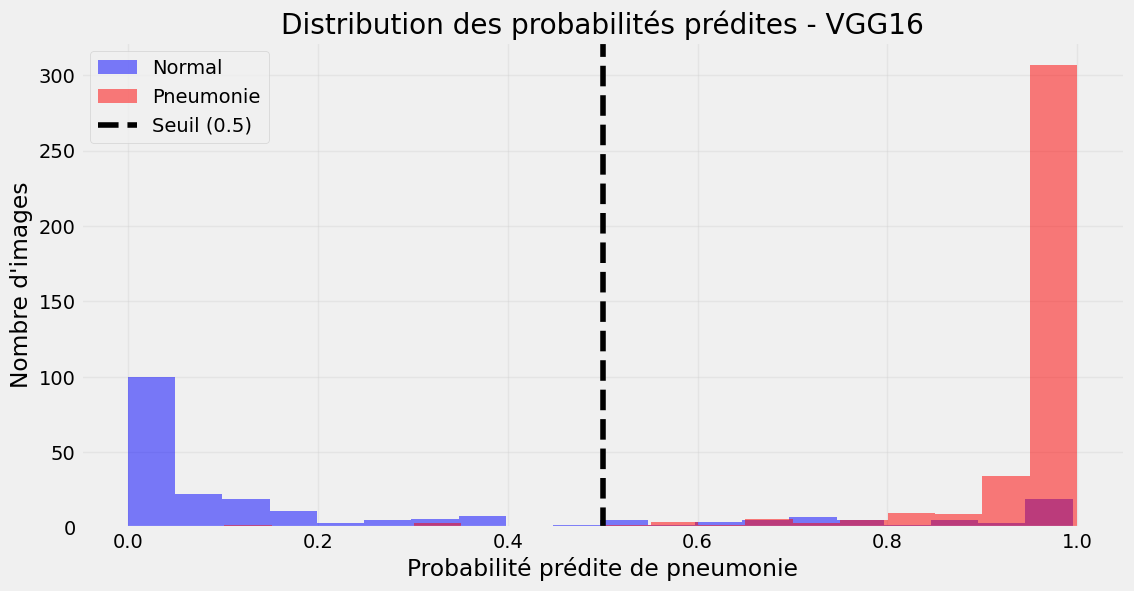


3. Modèle ResNet50
Création du modèle ResNet50...
94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_c

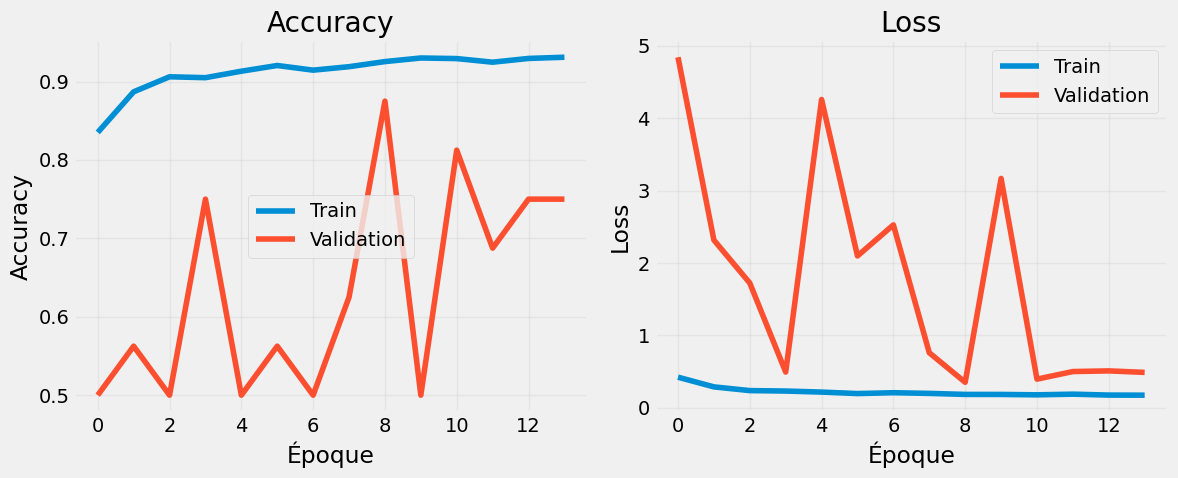


Évaluation du modèle ResNet50...

Résultats pour le modèle ResNet50:
Accuracy: 0.8558
Precision: 0.9261
Recall (Sensibilité): 0.8359
Specificity: 0.8889
F1-score: 0.8787
AUC: 0.9388
NPV: 0.7647

Matrice de confusion:
[[208  26]
 [ 64 326]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.76      0.89      0.82       234
   Pneumonie       0.93      0.84      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.87      0.86      0.86       624



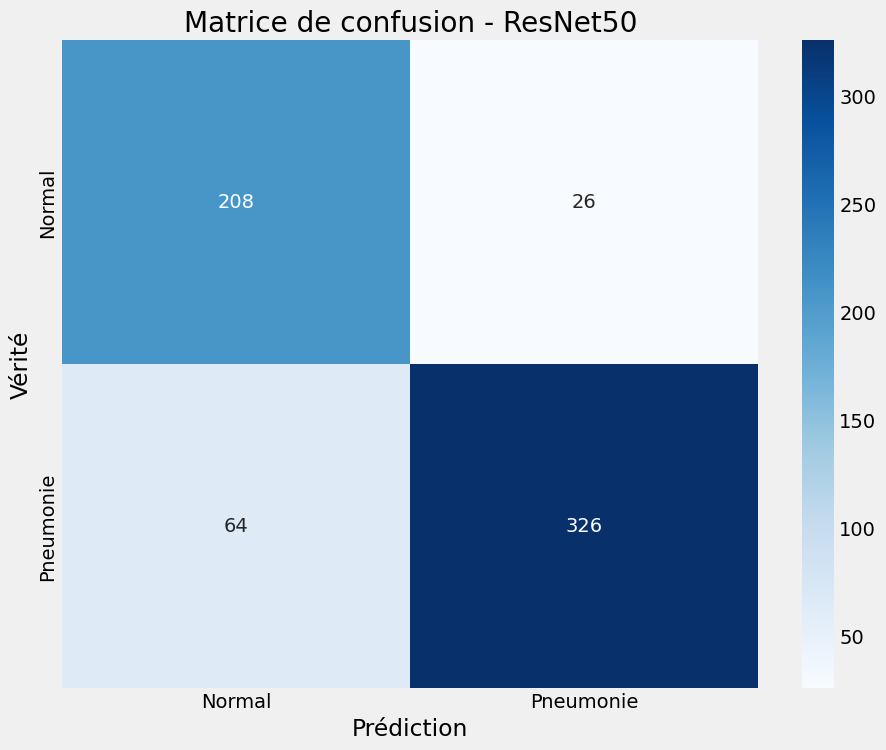

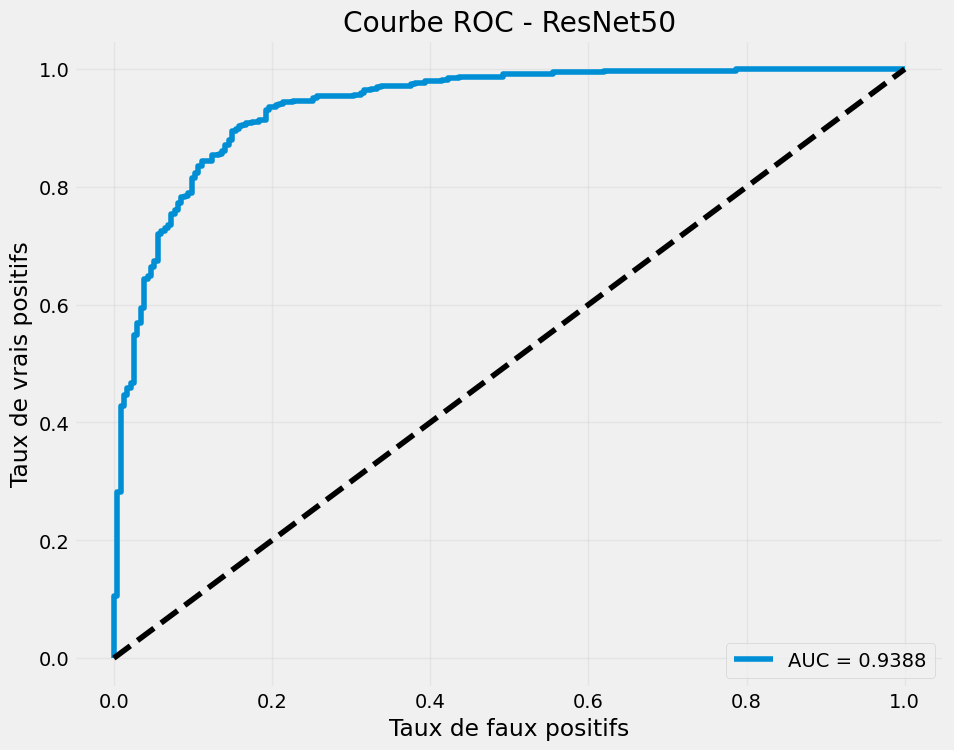

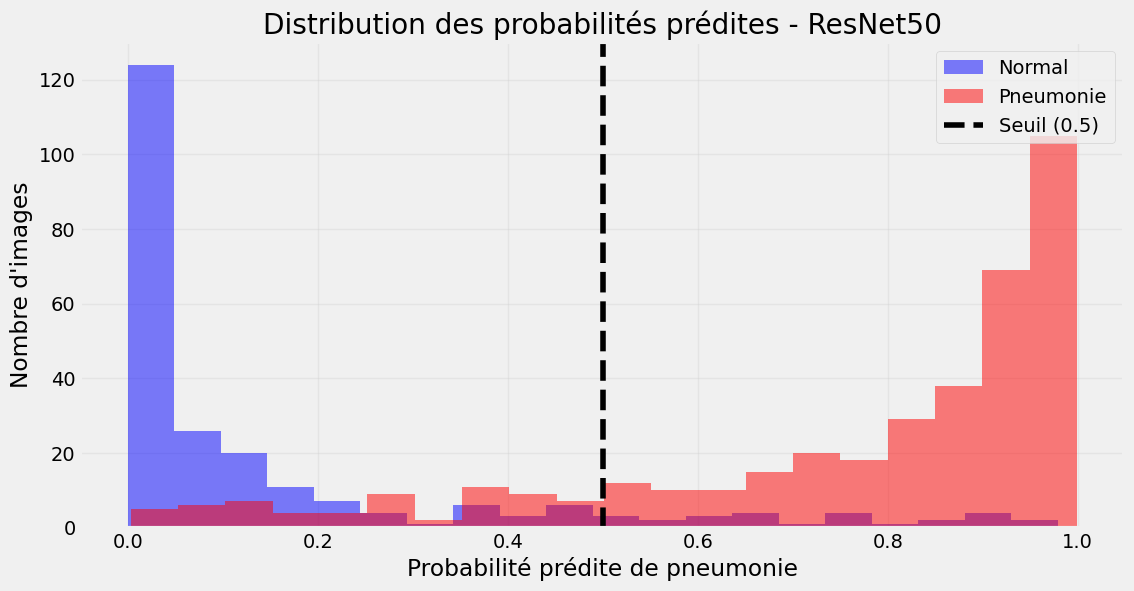


Comparaison des modèles
Comparaison des métriques:
          accuracy precision    recall specificity  f1_score       auc  \
CNN       0.862179  0.931818  0.841026    0.897436  0.884097  0.948784   
VGG16     0.895833  0.870159  0.979487     0.75641  0.921592  0.952312   
ResNet50  0.855769  0.926136  0.835897    0.888889  0.878706  0.938779   

               npv  
CNN       0.772059  
VGG16     0.956757  
ResNet50  0.764706  


<Figure size 1400x800 with 0 Axes>

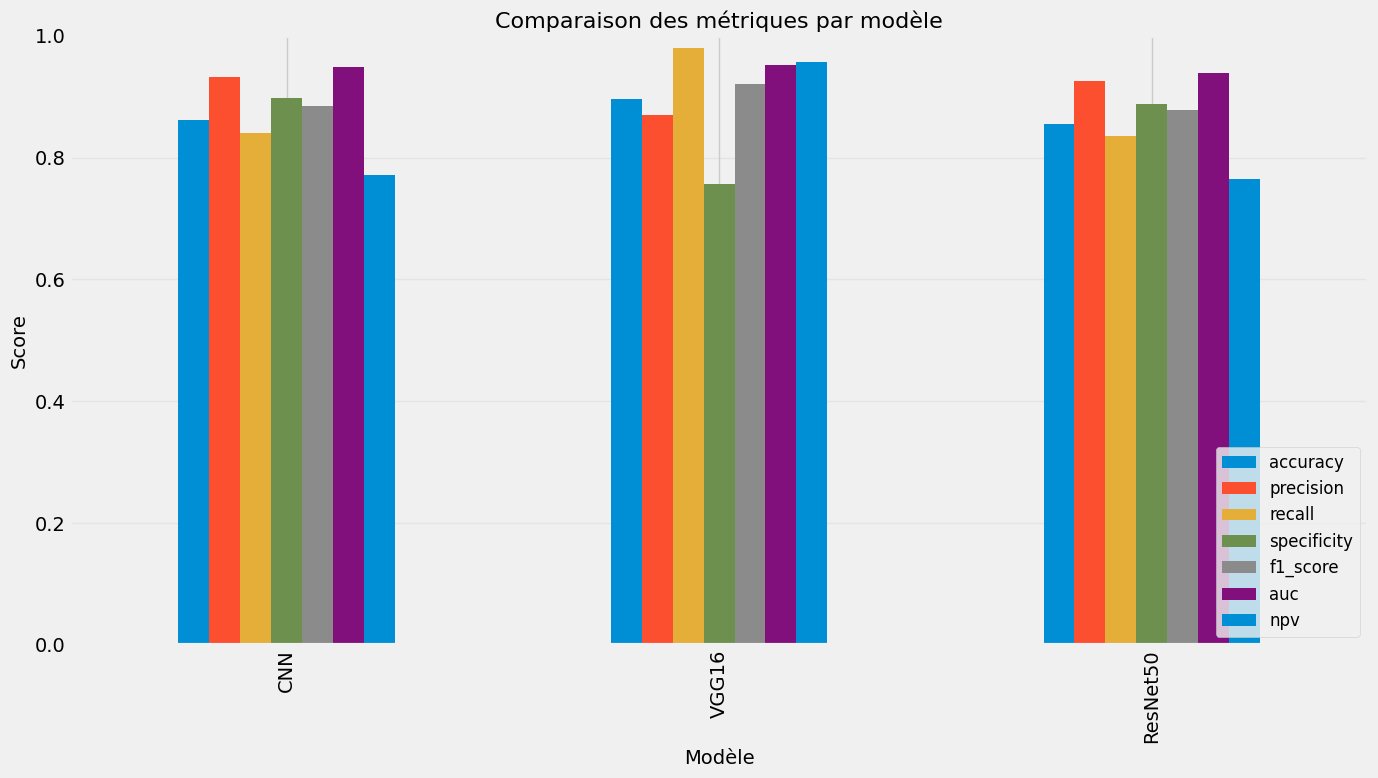

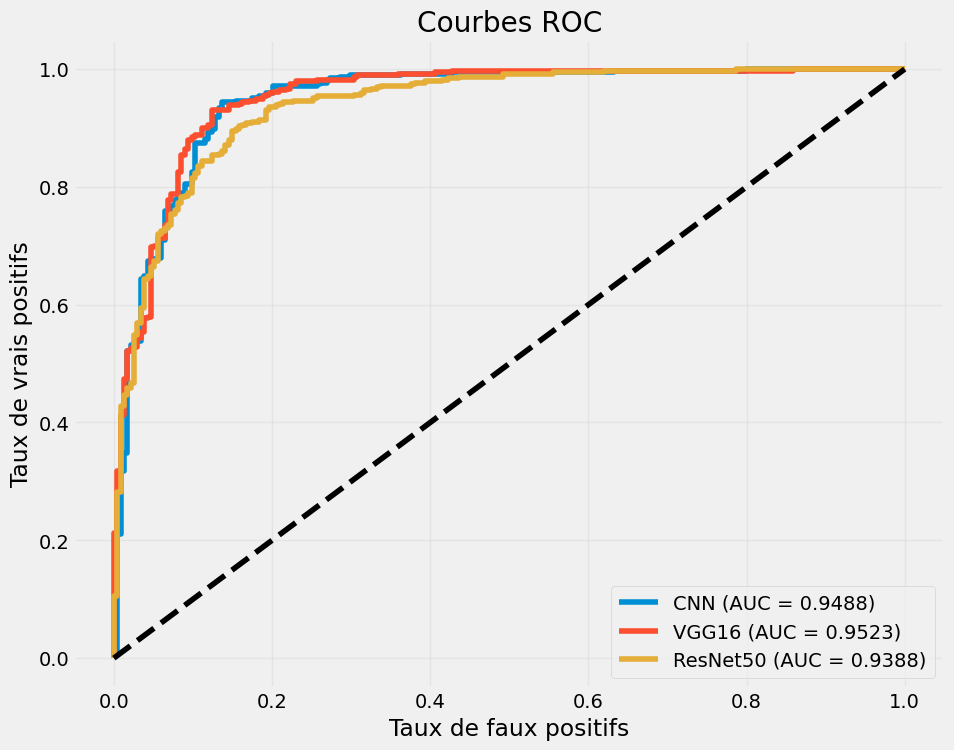

Résultats sauvegardés dans: C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results\model_comparison.csv


In [4]:
# Créer le répertoire de résultats s'il n'existe pas
results_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results'
os.makedirs(results_dir, exist_ok=True)

# Dictionnaires pour stocker les modèles, les résultats et les probabilités
models = {}
results = {}
probas = {}

# Vérifier si les données sont disponibles
if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
    print("Erreur: Les données d'entraînement, de validation ou de test sont vides.")
else:
    # 1. Modèle CNN
    print("\n" + "="*50)
    print("1. Modèle CNN")
    print("="*50)
    
    # Vérifier si le modèle est déjà entraîné
    cnn_model_path = os.path.join(results_dir, 'cnn_model.h5')
    if os.path.exists(cnn_model_path):
        print(f"Chargement du modèle CNN depuis {cnn_model_path}")
        cnn_model = load_model(cnn_model_path)
        models['CNN'] = cnn_model
    else:
        # Créer et entraîner le modèle CNN
        print("Création du modèle CNN...")
        cnn_model = create_cnn_model(input_shape=X_train[0].shape)
        
        # Afficher le résumé du modèle
        cnn_model.summary()
        
        # Entraîner le modèle
        print("\nEntraînement du modèle CNN...")
        cnn_model, cnn_history = train_model(
            cnn_model, 
            X_train, 
            y_train, 
            X_val, 
            y_val, 
            model_name='cnn_model',
            batch_size=32,
            epochs=20,
            use_augmentation=True
        )
        
        if cnn_model is not None:
            models['CNN'] = cnn_model
            
            # Visualiser l'historique d'entraînement
            if cnn_history is not None:
                # Tracer l'historique d'entraînement
                plt.figure(figsize=(12, 5))
                
                # Accuracy
                plt.subplot(1, 2, 1)
                plt.plot(cnn_history.history['accuracy'], label='Train')
                plt.plot(cnn_history.history['val_accuracy'], label='Validation')
                plt.title('Accuracy')
                plt.xlabel('Époque')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                # Loss
                plt.subplot(1, 2, 2)
                plt.plot(cnn_history.history['loss'], label='Train')
                plt.plot(cnn_history.history['val_loss'], label='Validation')
                plt.title('Loss')
                plt.xlabel('Époque')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
    
    # Évaluer le modèle CNN
    if 'CNN' in models:
        # Libérer la mémoire avant l'évaluation
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Évaluer le modèle
        cnn_metrics = evaluate_model(models['CNN'], X_test, y_test, model_name='CNN')
        
        # Stocker les résultats
        if cnn_metrics:
            results['CNN'] = cnn_metrics
            probas['CNN'] = cnn_metrics['y_pred_proba']
    
    # 2. Modèle VGG16
    print("\n" + "="*50)
    print("2. Modèle VGG16")
    print("="*50)
    
     # Vérifier si le modèle est déjà entraîné
    vgg16_model_path = os.path.join(results_dir, 'vgg16_model.h5')
    if os.path.exists(vgg16_model_path):
        print(f"Chargement du modèle VGG16 depuis {vgg16_model_path}")
        vgg16_model = load_model(vgg16_model_path)
        models['VGG16'] = vgg16_model
    else:
        # Créer et entraîner le modèle VGG16
        print("Création du modèle VGG16...")
        vgg16_model = create_vgg16_model(input_shape=X_train[0].shape)
        
        # Afficher le résumé du modèle
        vgg16_model.summary()
        
        # Libérer la mémoire avant l'entraînement
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Entraîner le modèle
        print("\nEntraînement du modèle VGG16...")
        vgg16_model, vgg16_history = train_model(
            vgg16_model, 
            X_train, 
            y_train, 
            X_val, 
            y_val, 
            model_name='vgg16_model',
            batch_size=16,  # Batch size plus petit pour VGG16
            epochs=20,
            use_augmentation=True
        )
        
        if vgg16_model is not None:
            models['VGG16'] = vgg16_model
            
            # Visualiser l'historique d'entraînement
            if vgg16_history is not None:
                # Tracer l'historique d'entraînement
                plt.figure(figsize=(12, 5))
                
                # Accuracy
                plt.subplot(1, 2, 1)
                plt.plot(vgg16_history.history['accuracy'], label='Train')
                plt.plot(vgg16_history.history['val_accuracy'], label='Validation')
                plt.title('Accuracy')
                plt.xlabel('Époque')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                # Loss
                plt.subplot(1, 2, 2)
                plt.plot(vgg16_history.history['loss'], label='Train')
                plt.plot(vgg16_history.history['val_loss'], label='Validation')
                plt.title('Loss')
                plt.xlabel('Époque')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
    
    # Évaluer le modèle VGG16
    if 'VGG16' in models:
        # Libérer la mémoire avant l'évaluation
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Évaluer le modèle
        vgg16_metrics = evaluate_model(models['VGG16'], X_test, y_test, model_name='VGG16')
        
        # Stocker les résultats
        if vgg16_metrics:
            results['VGG16'] = vgg16_metrics
            probas['VGG16'] = vgg16_metrics['y_pred_proba']
    
    # 3. Modèle ResNet50
    print("\n" + "="*50)
    print("3. Modèle ResNet50")
    print("="*50)
    
    # Vérifier si le modèle est déjà entraîné
    resnet50_model_path = os.path.join(results_dir, 'resnet50_model.h5')
    if os.path.exists(resnet50_model_path):
        print(f"Chargement du modèle ResNet50 depuis {resnet50_model_path}")
        resnet50_model = load_model(resnet50_model_path)
        models['ResNet50'] = resnet50_model
    else:
        # Créer et entraîner le modèle ResNet50
        print("Création du modèle ResNet50...")
        resnet50_model = create_resnet50_model(input_shape=X_train[0].shape)
        
        # Afficher le résumé du modèle
        resnet50_model.summary()
        
        # Libérer la mémoire avant l'entraînement
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Entraîner le modèle
        print("\nEntraînement du modèle ResNet50...")
        resnet50_model, resnet50_history = train_model(
            resnet50_model, 
            X_train, 
            y_train, 
            X_val, 
            y_val, 
            model_name='resnet50_model',
            batch_size=16,  # Batch size plus petit pour ResNet50
            epochs=20,
            use_augmentation=True
        )
        
        if resnet50_model is not None:
            models['ResNet50'] = resnet50_model
            
            # Visualiser l'historique d'entraînement
            if resnet50_history is not None:
                # Tracer l'historique d'entraînement
                plt.figure(figsize=(12, 5))
                
                # Accuracy
                plt.subplot(1, 2, 1)
                plt.plot(resnet50_history.history['accuracy'], label='Train')
                plt.plot(resnet50_history.history['val_accuracy'], label='Validation')
                plt.title('Accuracy')
                plt.xlabel('Époque')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                # Loss
                plt.subplot(1, 2, 2)
                plt.plot(resnet50_history.history['loss'], label='Train')
                plt.plot(resnet50_history.history['val_loss'], label='Validation')
                plt.title('Loss')
                plt.xlabel('Époque')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
    
    # Évaluer le modèle ResNet50
    if 'ResNet50' in models:
        # Libérer la mémoire avant l'évaluation
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Évaluer le modèle
        resnet50_metrics = evaluate_model(models['ResNet50'], X_test, y_test, model_name='ResNet50')
        
        # Stocker les résultats
        if resnet50_metrics:
            results['ResNet50'] = resnet50_metrics
            probas['ResNet50'] = resnet50_metrics['y_pred_proba']
    
    # Comparer les modèles
    if results:
        print("\n" + "="*50)
        print("Comparaison des modèles")
        print("="*50)
        
        # Créer un DataFrame pour comparer les métriques
        metrics_df = pd.DataFrame(results).T
        metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc', 'npv']]
        
        # Afficher le tableau de comparaison
        print("Comparaison des métriques:")
        print(metrics_df.round(4))
        
        # Visualiser les métriques sous forme de graphique à barres
        plt.figure(figsize=(14, 8))
        metrics_df.plot(kind='bar', figsize=(14, 8))
        plt.title('Comparaison des métriques par modèle', fontsize=16)
        plt.xlabel('Modèle', fontsize=14)
        plt.ylabel('Score', fontsize=14)
        plt.ylim(0, 1)
        plt.legend(loc='lower right', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Tracer les courbes ROC pour tous les modèles
        plt.figure(figsize=(10, 8))
        
        for model_name, y_pred_proba in probas.items():
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc = roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title('Courbes ROC')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Sauvegarder les résultats
        metrics_csv_path = os.path.join(results_dir, 'model_comparison.csv')
        metrics_df.to_csv(metrics_csv_path)
        print(f"Résultats sauvegardés dans: {metrics_csv_path}")


Visualisation des prédictions

Prédictions du modèle CNN:
20/20 [==============================] - 9s 424ms/step


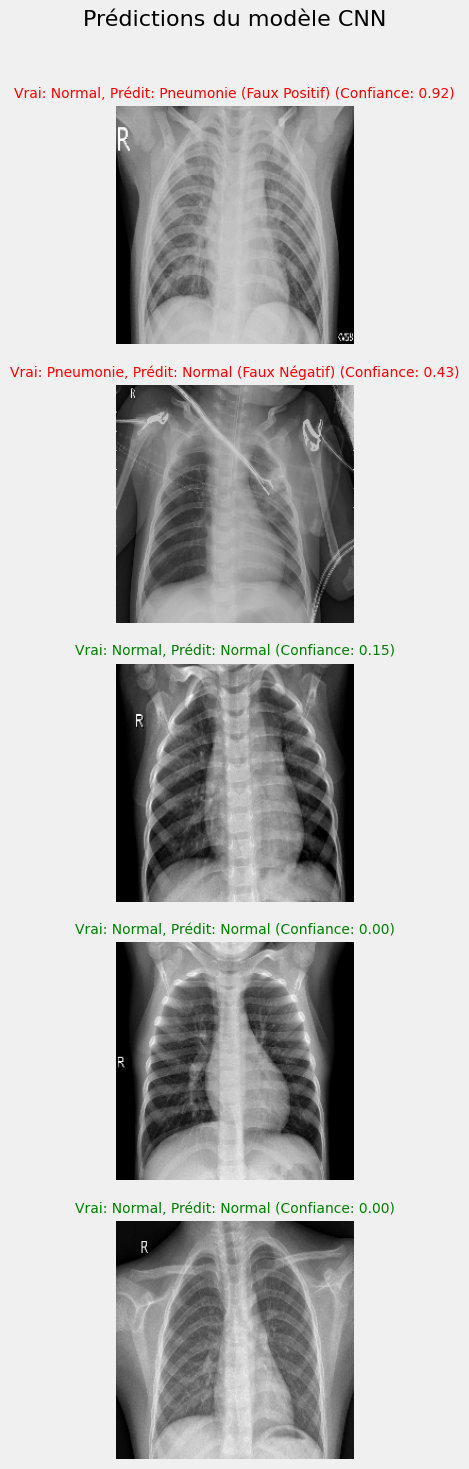


Prédictions du modèle VGG16:
20/20 [==============================] - 94s 5s/step


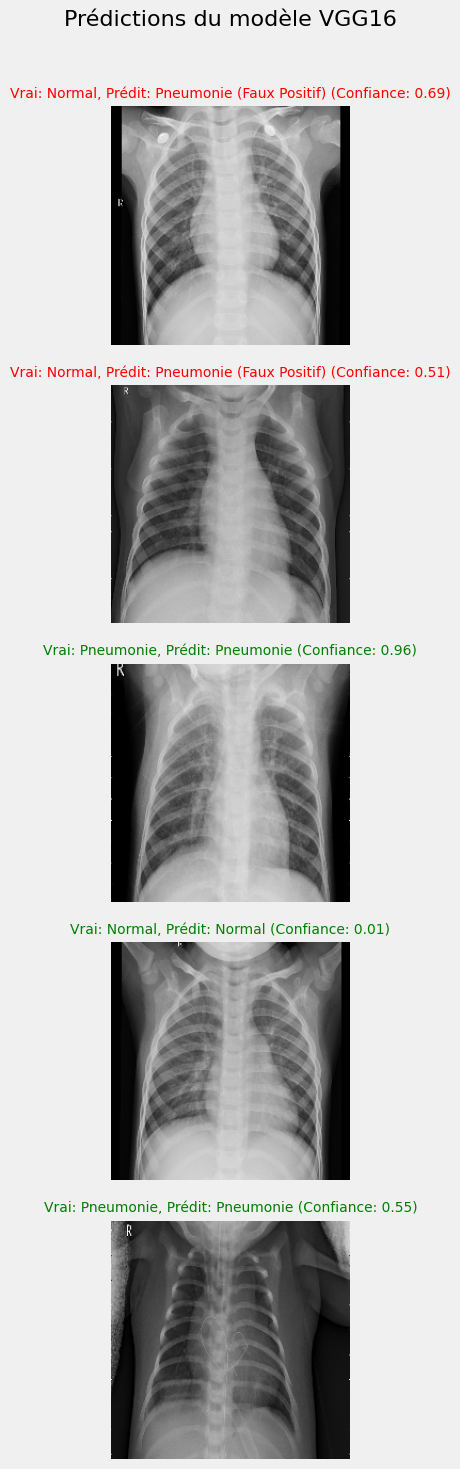


Prédictions du modèle ResNet50:
20/20 [==============================] - 38s 2s/step


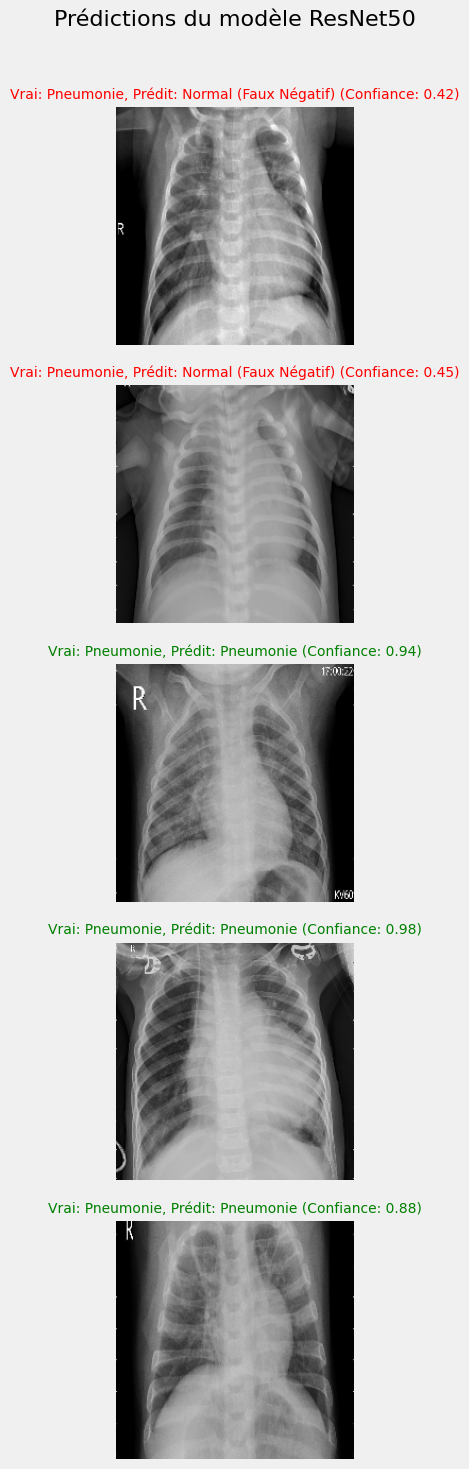

In [5]:
# Fonction pour visualiser les prédictions
def visualize_predictions(model, X_test, y_test, model_name='Modèle', num_samples=5):
    """
    Visualise quelques prédictions du modèle.
    
    Args:
        model: Modèle à utiliser pour les prédictions
        X_test (numpy.ndarray): Images de test
        y_test (numpy.ndarray): Étiquettes de test
        model_name (str): Nom du modèle
        num_samples (int): Nombre d'exemples à visualiser
    """
    # Vérifier si le modèle et les données sont disponibles
    if model is None:
        print(f"Le modèle {model_name} n'est pas disponible.")
        return
    
    if len(X_test) == 0 or len(y_test) == 0:
        print(f"Les données de test sont vides. Impossible de visualiser les prédictions du modèle {model_name}.")
        return
    
    try:
        # Faire des prédictions
        y_pred_proba = model.predict(X_test).flatten()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Identifier les exemples corrects et incorrects
        correct_indices = np.where(y_pred == y_test)[0]
        incorrect_indices = np.where(y_pred != y_test)[0]
        
        # Sélectionner des exemples variés
        selected_indices = []
        
        # Essayer de sélectionner des exemples incorrects s'il y en a
        num_incorrect = min(num_samples // 2, len(incorrect_indices))
        if num_incorrect > 0 and len(incorrect_indices) > 0:
            selected_indices.extend(np.random.choice(incorrect_indices, num_incorrect, replace=False))
        
        # Compléter avec des exemples corrects
        num_correct = num_samples - len(selected_indices)
        if num_correct > 0 and len(correct_indices) > 0:
            selected_indices.extend(np.random.choice(correct_indices, num_correct, replace=False))
        
        # Si nous n'avons pas assez d'exemples, sélectionner des exemples aléatoires
        if len(selected_indices) < num_samples:
            remaining = num_samples - len(selected_indices)
            all_indices = np.arange(len(X_test))
            remaining_indices = np.setdiff1d(all_indices, selected_indices)
            if len(remaining_indices) > 0:
                selected_indices.extend(np.random.choice(remaining_indices, min(remaining, len(remaining_indices)), replace=False))
        
        # Visualiser les exemples
        plt.figure(figsize=(15, 3 * min(num_samples, len(selected_indices))))
        
        for i, idx in enumerate(selected_indices):
            plt.subplot(min(num_samples, len(selected_indices)), 1, i+1)
            plt.imshow(X_test[idx])
            
            # Déterminer la couleur en fonction de la prédiction
            color = 'green' if y_pred[idx] == y_test[idx] else 'red'
            
            # Déterminer les libellés des classes
            true_label = 'Pneumonie' if y_test[idx] == 1 else 'Normal'
            pred_label = 'Pneumonie' if y_pred[idx] == 1 else 'Normal'
            
            # Déterminer le type d'erreur
            error_type = ""
            if y_pred[idx] != y_test[idx]:
                if y_test[idx] == 0 and y_pred[idx] == 1:
                    error_type = " (Faux Positif)"
                else:
                    error_type = " (Faux Négatif)"
            
            # Afficher le titre avec les informations de prédiction
            plt.title(f"Vrai: {true_label}, Prédit: {pred_label}{error_type} (Confiance: {y_pred_proba[idx]:.2f})", 
                     color=color, fontsize=10)
            
            # Désactiver les axes
            plt.axis('off')
        
        plt.suptitle(f'Prédictions du modèle {model_name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    
    except Exception as e:
        print(f"Erreur lors de la visualisation des prédictions du modèle {model_name}: {e}")
        import traceback
        traceback.print_exc()

# Visualiser les prédictions pour chaque modèle
if models:
    print("\n" + "="*50)
    print("Visualisation des prédictions")
    print("="*50)
    
    for model_name, model in models.items():
        print(f"\nPrédictions du modèle {model_name}:")
        
        # Libérer la mémoire avant de visualiser les prédictions
        gc.collect()
        tf.keras.backend.clear_session()
        
        visualize_predictions(model, X_test, y_test, model_name)

In [6]:
# Fonction pour sauvegarder les résultats
def save_results(results, probas, X_test, y_test, models):
    """
    Sauvegarde les résultats d'évaluation des modèles.
    
    Args:
        results (dict): Dictionnaire contenant les métriques pour chaque modèle
        probas (dict): Dictionnaire contenant les probabilités prédites pour chaque modèle
        X_test (numpy.ndarray): Images de test
        y_test (numpy.ndarray): Étiquettes de test
        models (dict): Dictionnaire contenant les modèles entraînés
    """
    try:
        # Créer le dossier results s'il n'existe pas
        results_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results'
        os.makedirs(results_dir, exist_ok=True)
        
        print(f"Sauvegarde des résultats dans le dossier: {results_dir}")
        
        # Sauvegarder les métriques dans un fichier CSV
        if results:
            metrics_df = pd.DataFrame(results).T
            metrics_csv_path = os.path.join(results_dir, 'model_metrics.csv')
            metrics_df.to_csv(metrics_csv_path)
            print(f"Métriques sauvegardées dans: {metrics_csv_path}")
        
        # Sauvegarder les probabilités prédites
        if probas:
            probas_df = pd.DataFrame()
            for model_name, proba in probas.items():
                probas_df[model_name] = proba
            probas_df['true_label'] = y_test
            
            probas_csv_path = os.path.join(results_dir, 'predicted_probabilities.csv')
            probas_df.to_csv(probas_csv_path)
            print(f"Probabilités prédites sauvegardées dans: {probas_csv_path}")
        
        # Sauvegarder quelques exemples d'images avec leurs prédictions
        if X_test is not None and y_test is not None and models:
            samples_dir = os.path.join(results_dir, 'sample_predictions')
            os.makedirs(samples_dir, exist_ok=True)
            
            # Sélectionner quelques exemples aléatoires
            num_samples = min(10, len(X_test))
            indices = np.random.choice(len(X_test), num_samples, replace=False)
            
            for i, idx in enumerate(indices):
                fig, axes = plt.subplots(1, len(models) + 1, figsize=(5 * (len(models) + 1), 5))
                
                # Afficher l'image originale
                axes[0].imshow(X_test[idx])
                axes[0].set_title(f"Vrai: {'Pneumonie' if y_test[idx] == 1 else 'Normal'}")
                axes[0].axis('off')
                
                # Afficher les prédictions de chaque modèle
                for j, (model_name, model) in enumerate(models.items()):
                    proba = probas[model_name][idx] if model_name in probas else model.predict(X_test[idx:idx+1])[0][0]
                    pred = 1 if proba >= 0.5 else 0
                    
                    axes[j+1].imshow(X_test[idx])
                    color = 'green' if pred == y_test[idx] else 'red'
                    axes[j+1].set_title(f"{model_name}\nPrédit: {'Pneumonie' if pred == 1 else 'Normal'}\n({proba:.2f})", color=color)
                    axes[j+1].axis('off')
                
                # Sauvegarder l'image
                plt.tight_layout()
                plt.savefig(os.path.join(samples_dir, f'sample_{i+1}.png'), dpi=150)
                plt.close()
            
            print(f"Exemples de prédictions sauvegardés dans: {samples_dir}")
        
        return results_dir
    
    except Exception as e:
        print(f"Erreur lors de la sauvegarde des résultats: {e}")
        import traceback
        traceback.print_exc()
        return None

# Sauvegarder les résultats
if results and probas and X_test is not None and y_test is not None and models:
    print("\n" + "="*50)
    print("Sauvegarde des résultats")
    print("="*50)
    
    save_results(results, probas, X_test, y_test, models)


Sauvegarde des résultats
Sauvegarde des résultats dans le dossier: C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results
Métriques sauvegardées dans: C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results\model_metrics.csv
Probabilités prédites sauvegardées dans: C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results\predicted_probabilities.csv
Exemples de prédictions sauvegardés dans: C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\results\sample_predictions
